# gyro-interp using Bouma+2024b data
* https://ui.adsabs.harvard.edu/abs/2024ApJ...976..234B/abstract

In [1]:
import sys

# make sure you are using `gyrointerp` environment
assert sys.executable.split('/')[5]=='gyrointerp'

In [2]:
# Inside this jupyter lab, do not use `pip install xxx`, instead use:
# import sys
# !{sys.executable} -m pip install xxx

In [3]:
# check if package is installed
!{sys.executable} -m pip show gyrointerp

Name: gyrointerp
Version: 0.5
Summary: Gyrochronology via interpolation of open cluster rotation sequences.
Home-page: https://github.com/lgbouma/gyro-interp
Author: Luke Bouma
Author-email: bouma.luke@gmail.com
License: MIT
Location: /mnt_ut3/raid_ut3/home/jerome/github/research/project/ext_tools/gyro-interp
Editable project location: /mnt_ut3/raid_ut3/home/jerome/github/research/project/ext_tools/gyro-interp
Requires: astropy, matplotlib, numpy, pandas, scipy
Required-by: 


## Table 1 in Bouma+2024b

In [149]:
from astropy.io import ascii

url = "https://content.cld.iop.org/journals/0004-637X/976/2/234/revision1/apjad855ft1_mrt.txt"
tab = ascii.read(url)
tab[:3]

KIC,KOI,Kepler,Disp,Teff,e_Teff,r_Teff,Prot,e_Prot,r_Prot,EW,e_EW,tGyro,E_tGyro,e_tGyro,2Up-tGyro,2Lo-tGyro,tLi,E_tLi,e_tLi,Rp,r_Rp,Per,StarFlag,PlanetFlag,HiRes,Consist,f_tGyro,f_tLi
,,,,K,K,,d,d,,1e-13 m,1e-13 m,Myr,Myr,Myr,Myr,Myr,1e-13 m,1e-13 m,1e-13 m,Rgeo,,d,,,,,,
int64,str9,str14,str9,int64,int64,str19,str5,str5,str19,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,str19,float64,int64,int64,int64,str5,str6,str5
6184894,K05245.01,Kepler-1627 b,CONFIRMED,5357,95,2020AJ....159..280B,2.620,0.026,2021ApJS..255...17S,225,7,81,158,55,413,77,51,38,27,3.79,2022AJ....163..121B,7.2,2176,0,1,Yes,--,--
10736489,K07368.01,Kepler-1974 b,CONFIRMED,5068,76,2020AJ....159..280B,2.560,0.026,2021ApJS..255...17S,248,4,88,183,60,420,84,54,47,25,2.22,2022AJ....164..215B,6.84,2560,0,1,Yes,--,--
10717220,K06228.01,Kepler-1644 b,CONFIRMED,5521,109,2020AJ....159..280B,1.430,0.014,2021ApJS..255...17S,-2,13,77,144,53,409,74,--,--,--,1.88,10.26133/NEA4,21.09,2690,4,1,No,--,> 767


In [150]:
df = tab.to_pandas()
df.shape

(2461, 29)

In [151]:
df.KIC.unique().shape

(1734,)

In [162]:
# filter only confirmed planets (exclude Kepler candidates)

idx = (df.Disp=='CONFIRMED') & \
     (df.Teff>3800) & \
     (df.Teff<6200)
      # df.StarFlag==0 & \
      # df.PlanetFlag==0 &\

In [163]:
# filter
df = df[idx]
df = df.drop_duplicates(subset='KIC', keep='first')
df.shape

(1260, 29)

In [164]:
df.columns

Index(['KIC', 'KOI', 'Kepler', 'Disp', 'Teff', 'e_Teff', 'r_Teff', 'Prot',
       'e_Prot', 'r_Prot', 'EW', 'e_EW', 'tGyro', 'E_tGyro', 'e_tGyro',
       '2Up-tGyro', '2Lo-tGyro', 'tLi', 'E_tLi', 'e_tLi', 'Rp', 'r_Rp', 'Per',
       'StarFlag', 'PlanetFlag', 'HiRes', 'Consist', 'f_tGyro', 'f_tLi'],
      dtype='object')

In [165]:
# convert to float
cols = ['Kepler','Prot','Teff','e_Prot','e_Teff', 'tGyro','E_tGyro','e_tGyro','tLi','E_tLi','e_tLi']
df[cols[1:]] = df[cols[1:]].astype(float)

## plot data

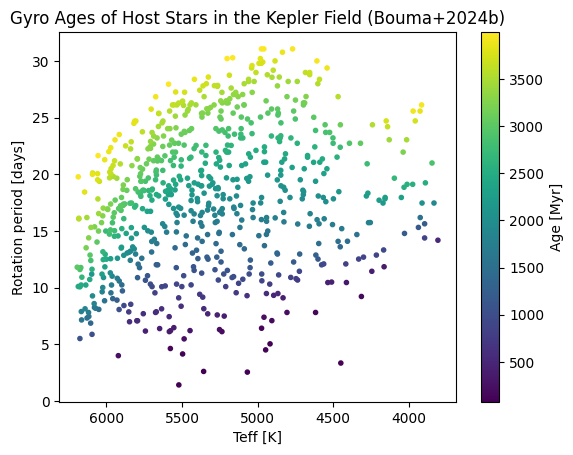

In [166]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
s = ax.scatter(df.Teff, df.Prot, marker='.', c=df.tGyro)
fig.colorbar(s, label='Age [Myr]')
ax.xaxis.set_inverted(True)
ax.update({
    'xlabel': 'Teff [K]',
    'ylabel': 'Rotation period [days]',
    'title': 'Gyro Ages of Host Stars in the Kepler Field (Bouma+2024b)'
    });

## plot also models from gyro-interp

https://gyro-interp.readthedocs.io/en/latest/examples.html#visual-interpolation-for-a-star-s-age

In [146]:
df.Teff.min().round(-2), df.Teff.max().round(-2)

(np.float64(3400.0), np.float64(6800.0))

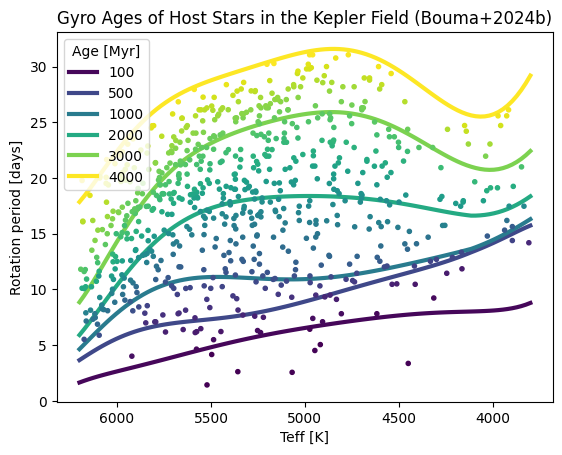

In [192]:
from gyrointerp.models import slow_sequence
from matplotlib.colors import ListedColormap
import numpy as np

tmin, tmax = df.tGyro.min(), df.tGyro.max()
slow_seq_ages = [round(tmin/100)*100,
                 500,1000,2000,3000,
                 round(tmax/1000)*1000]
Nages = len(slow_seq_ages)
# Tmin, Tmax = df.Teff.min().round(-2), df.Teff.max().round(-2)
Tmin, Tmax = 3800, 6200
Teff = np.linspace(Tmin, Tmax, 100)
colors = ListedColormap(plt.cm.viridis(np.linspace(tmin/tmax, 1, Nages))).colors

fig, ax = plt.subplots()

for i,slow_seq_age in enumerate(slow_seq_ages):
    Prot = slow_sequence(
        Teff, slow_seq_age, poly_order=7,
        interp_method='pchip_m67'
    )
    ax.plot(
        Teff, Prot, color=colors[i], linewidth=3, zorder=-1, label=f"{slow_seq_age}"
    )

# kepler data
s = ax.scatter(df.Teff, df.Prot, marker='.', c=df.tGyro)
# fig.colorbar(s, label='Age [Myr]')
ax.xaxis.set_inverted(True)
ax.update({
    'xlabel': 'Teff [K]',
    'ylabel': 'Rotation period [days]',
    'title': 'Gyro Ages of Host Stars in the Kepler Field (Bouma+2024b)'
    });
ax.legend(title='Age [Myr]', loc='upper left')

## top candidates (age from gyro & lithium < 1 Gyr)

In [193]:
# get consistent tGyro and tLi
idx = df['Consist']=='Yes'
# remove columns with NaN
df = df.loc[idx,cols].dropna()
df.shape

(45, 11)

In [194]:
#filter main results: host stars with age<1Gyr (E_age = age upper limit)
idx = df[['E_tGyro','E_tLi']]<1000
idx.head()

,E_tGyro,E_tLi
0,True,True
1,True,True
3,True,True
5,True,True
8,True,True


In [195]:
#make sure idx is True when both columns are True
idx.all(axis=1)

0       True
1       True
3       True
5       True
8       True
9       True
11      True
12      True
13      True
15      True
17      True
19      True
23      True
28      True
31      True
32      True
33      True
44      True
53     False
58     False
59     False
79     False
105    False
129    False
143    False
160    False
174    False
190    False
216    False
223    False
225    False
251    False
263    False
294    False
301    False
345    False
352    False
381    False
385    False
418    False
469    False
493    False
545    False
578    False
639    False
dtype: bool

In [196]:
df_young = df[idx.all(axis=1)]
df_young

,Kepler,Prot,Teff,e_Prot,e_Teff,tGyro,E_tGyro,e_tGyro,tLi,E_tLi,e_tLi
0,Kepler-1627 b,2.62,5357.0,0.026,95.0,81.0,158.0,55.0,51.0,38.0,27.0
1,Kepler-1974 b,2.56,5068.0,0.026,76.0,88.0,183.0,60.0,54.0,47.0,25.0
3,Kepler-1643 b,5.05,4918.0,0.050,83.0,79.0,182.0,54.0,191.0,92.0,76.0
5,Kepler-1529 b,6.43,4974.0,0.060,99.0,109.0,117.0,71.0,90.0,53.0,39.0
8,Kepler-1930 b,7.10,4906.0,0.070,89.0,174.0,106.0,65.0,115.0,55.0,49.0
9,Kepler-1928 b,4.64,5577.0,0.046,86.0,148.0,102.0,87.0,189.0,150.0,94.0
11,Kepler-1313 b,6.13,5236.0,0.060,85.0,197.0,112.0,91.0,174.0,96.0,72.0
12,Kepler-1565 b,7.40,4958.0,0.070,96.0,230.0,111.0,85.0,174.0,81.0,72.0
13,Kepler-1521 b,7.82,4806.0,0.080,80.0,207.0,98.0,68.0,176.0,79.0,69.0
15,Kepler-63 b,5.49,5486.0,0.050,82.0,223.0,98.0,92.0,542.0,475.0,256.0


## confirm published ages using gyro-interp

### age < 0.1 Gyr

In [197]:
name = "Kepler-1627 b"
d = df.query("Kepler==@name").squeeze()
d

Kepler     Kepler-1627 b
Prot                2.62
Teff              5357.0
e_Prot             0.026
e_Teff              95.0
tGyro               81.0
E_tGyro            158.0
e_tGyro             55.0
tLi                 51.0
E_tLi               38.0
e_tLi               27.0
Name: 0, dtype: object

In [198]:
Prot = d.Prot
Teff = d.Teff
Prot_err = d.e_Prot
Teff_err = d.e_Teff

In [18]:
import numpy as np
from gyrointerp import gyro_age_posterior
from gyrointerp import get_summary_statistics

# uniformly spaced grid between 0 and 2600 Myr
age_grid = np.linspace(0, 2600, 500)

# calculate the age posterior - takes ~30 seconds
age_posterior = gyro_age_posterior(Prot, 
                                   Teff, 
                                   Prot_err=Prot_err, 
                                   Teff_err=Teff_err, 
                                   age_grid=age_grid,
                                   #bounds_error='4gyrextrap', #for older star
)

# calculate dictionary of summary statistics
result = get_summary_statistics(age_grid, age_posterior)
print(f"Age = {result['median']} +{result['+1sigma']} -{result['-1sigma']} Myr.")

[W 250327 15:47:40 gyro_posterior:361] WARNING: imposing period uncertainty floor of 0.03d The purpose of this floor is to prevent N_grid from growing too large.  This is justified because the gyro model has no information content on this scale.


Age = 80.79 +158.8 -55.19 Myr.


In [19]:
#compare with published results
print(f"age of {name} = {d['tGyro']} +{d['E_tGyro']} -{d['e_tGyro']}Myr")

age of Kepler-1627 b = 81.0 +158.0 -55.0Myr


## plot age distribution

In [ ]:
# import custom code from the `code` directory
import sys
sys.path.insert(0, '../code'

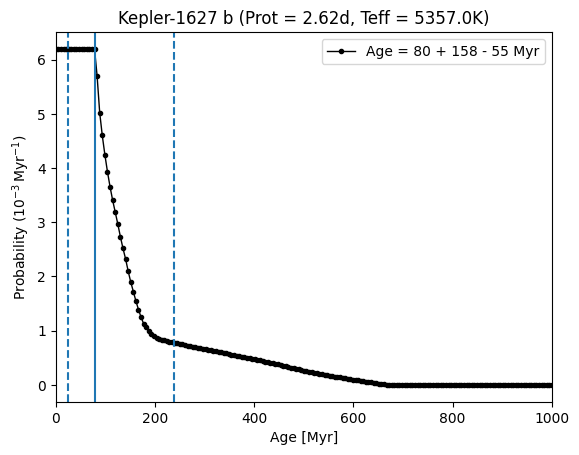

In [21]:
from kenmon import plot_age_posterior
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid)

fp = name.replace(' ','')+'_age_gyro.png'
fig.savefig(fp, bbox_inches='tight')

### 0.1 < age < 1 Gyr

In [22]:
# units: days
name = 'Kepler-447 b'
d = df.query("Kepler==@name").squeeze()
Prot = d.Prot
Teff = d.Teff
Prot_err = d.e_Prot
Teff_err = d.e_Teff

# calculate the age posterior at each age in `age_grid`
age_posterior = gyro_age_posterior(
    Prot, Teff,
    Prot_err=Prot_err, Teff_err=Teff_err,
    age_grid=age_grid,
    # bounds_error='4gyrextrap', #for older star
)

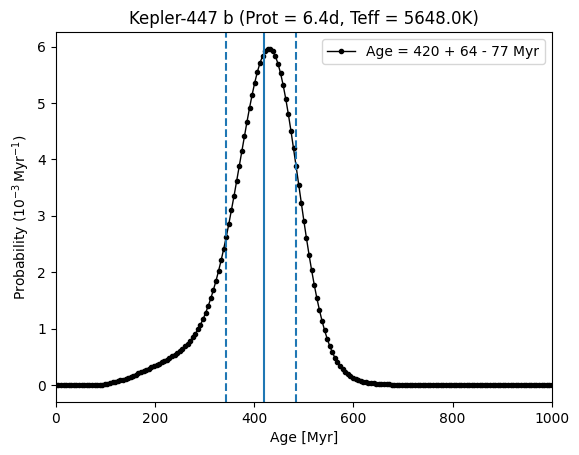

In [23]:
result = get_summary_statistics(age_grid, age_posterior)
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid)

In [24]:
#compare with published results
print(f"age of {name} = {d['tGyro']} +{d['E_tGyro']} -{d['e_tGyro']}Myr")

age of Kepler-447 b = 420.0 +64.0 -78.0Myr


### age > 1 Gyr

In [32]:
# units: days
name = 'Kepler-1061 b'
d = df.query("Kepler==@name").squeeze()
Prot = d.Prot
Teff = d.Teff
Prot_err = d.e_Prot
Teff_err = d.e_Teff

# uniformly spaced grid between 0 and 2600 Myr
age_grid = np.linspace(0, 4000, 500)

# calculate the age posterior at each age in `age_grid`
age_posterior = gyro_age_posterior(
    Prot, Teff,
    Prot_err=Prot_err, Teff_err=Teff_err,
    age_grid=age_grid,
    bounds_error='4gyrextrap', #for older star
)

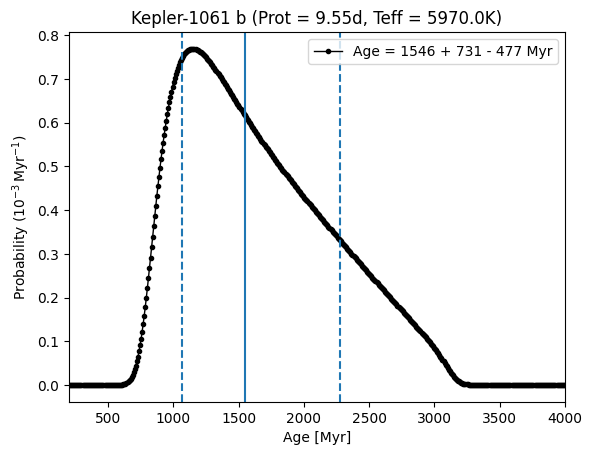

In [45]:
result = get_summary_statistics(age_grid, age_posterior)
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid, xlim=[200,4000])

In [46]:
#compare with published results
print(f"age of {name} = {d['tGyro']} +{d['E_tGyro']} -{d['e_tGyro']}Myr")

age of Kepler-1061 b = 1553.0 +760.0 -482.0Myr


## Note

* 100<age<1000 Myr posterior looks Gaussian so the age limits are more reliable.

## All stars

https://gyro-interp.readthedocs.io/en/latest/examples.html#ages-for-many-stars

In [199]:
df_young['ID'] = df_young.Kepler.str.replace(' ', '')
df_young

/tmp/ipykernel_2242554/3356386859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_young['ID'] = df_young.Kepler.str.replace(' ', '')


,Kepler,Prot,Teff,e_Prot,e_Teff,tGyro,E_tGyro,e_tGyro,tLi,E_tLi,e_tLi,ID
0,Kepler-1627 b,2.62,5357.0,0.026,95.0,81.0,158.0,55.0,51.0,38.0,27.0,Kepler-1627b
1,Kepler-1974 b,2.56,5068.0,0.026,76.0,88.0,183.0,60.0,54.0,47.0,25.0,Kepler-1974b
3,Kepler-1643 b,5.05,4918.0,0.050,83.0,79.0,182.0,54.0,191.0,92.0,76.0,Kepler-1643b
5,Kepler-1529 b,6.43,4974.0,0.060,99.0,109.0,117.0,71.0,90.0,53.0,39.0,Kepler-1529b
8,Kepler-1930 b,7.10,4906.0,0.070,89.0,174.0,106.0,65.0,115.0,55.0,49.0,Kepler-1930b
9,Kepler-1928 b,4.64,5577.0,0.046,86.0,148.0,102.0,87.0,189.0,150.0,94.0,Kepler-1928b
11,Kepler-1313 b,6.13,5236.0,0.060,85.0,197.0,112.0,91.0,174.0,96.0,72.0,Kepler-1313b
12,Kepler-1565 b,7.40,4958.0,0.070,96.0,230.0,111.0,85.0,174.0,81.0,72.0,Kepler-1565b
13,Kepler-1521 b,7.82,4806.0,0.080,80.0,207.0,98.0,68.0,176.0,79.0,69.0,Kepler-1521b
15,Kepler-63 b,5.49,5486.0,0.050,82.0,223.0,98.0,92.0,542.0,475.0,256.0,Kepler-63b


In [229]:
from gyrointerp import gyro_age_posterior_list, get_summary_statistics

Teffs = df_young.Teff
Teff_errs = df_young.e_Teff
Prots = df_young.Prot
Prot_errs = df_young.e_Prot
# Let's pass optional star IDs to name the posterior csv files.
star_ids = df_young.ID

# The output posteriors will be cached at ~/.gyrointerp_cache/{cache_id}
cache_id = 'Bouma2024b'

#typically, Prot<17 has age < 1 Gy
age_grid = np.linspace(0, 2600, 500)

print(f"Running {len(star_ids)} targets...")

# This function will compute the posteriors, and cache them to CSV files
csvpaths = gyro_age_posterior_list(
    cache_id, 
    Prots, 
    Teffs, 
    Prot_errs=Prot_errs, 
    Teff_errs=Teff_errs,
    star_ids=star_ids, 
    age_grid=age_grid, 
    bounds_error="4gyrlimit",
    interp_method="pchip_m67"
)

[I 250328 14:09:21 gyro_posterior:751] Got N_tasks=18...
[I 250328 14:09:21 gyro_posterior:752] 2025-03-28T14:09:21.850246 beginning gyro_age_posterior_list


Running 18 targets...


[W 250328 14:09:22 gyro_posterior:361] WARNING: imposing period uncertainty floor of 0.03d The purpose of this floor is to prevent N_grid from growing too large.  This is justified because the gyro model has no information content on this scale.
[W 250328 14:09:22 gyro_posterior:361] WARNING: imposing period uncertainty floor of 0.03d The purpose of this floor is to prevent N_grid from growing too large.  This is justified because the gyro model has no information content on this scale.
[I 250328 14:10:11 gyro_posterior:518] Wrote /ut3/jerome/.gyrointerp_cache/Bouma2024b/Kepler-67b_Prot10.3900_Teff5126.0_limitgrid_defaultparameters_posterior.csv
[I 250328 14:10:11 gyro_posterior:525] Wrote /ut3/jerome/.gyrointerp_cache/Bouma2024b/Kepler-67b_Prot10.3900_Teff5126.0_limitgrid_defaultparameters.csv
[I 250328 14:10:21 gyro_posterior:518] Wrote /ut3/jerome/.gyrointerp_cache/Bouma2024b/Kepler-1521b_Prot7.8200_Teff4806.0_limitgrid_defaultparameters_posterior.csv
[I 250328 14:10:21 gyro_posteri

In [230]:
import pandas as pd

outdir = 'Bouma2024b'
# Read the posteriors and print their summary statistics.
results = {}
for csvpath, Prot, Teff in zip(sorted(csvpaths), Prots, Teffs):
    try:
        name = csvpath.split('/')[-1].split('_')[0]
        df = pd.read_csv(csvpath)
        age_grid = df.age_grid.values
        age_post = df.age_post.values
        r = get_summary_statistics(age_grid, age_post)
        results[name] = {'Prot': Prot,
                         'Teff': Teff,
                         'age_med': r['median'],
                         'age_lo': r['-1sigma'],
                         'age_hi': r['+1sigma']
        }
        if False:
            # plot
            xlim = (r['median']-r['-3sigma'], r['median']+r['+3sigma'])
            fig = plot_age_posterior(name, Prot, Teff, age_post, r, age_grid, xlim=xlim)
            # save plot
            fp = f'{outdir}/{name}_age_gyro.png'
            fig.savefig(fp, bbox_inches='tight')
            
            msg = f"Age = {r['median']} +{r['+1sigma']} -{r['-1sigma']} Myr."
            print(f"Teff {int(Teff)} Prot {Prot:.2f} {msg}")
        
        results = pd.DataFrame(results)
    except Exception as e:
        print(e)

In [231]:
results.T.head()

,Prot,Teff,age_med,age_lo,age_hi
Kepler-1312b,2.62,5357.0,357.34,108.66,75.00
Kepler-1313b,2.56,5068.0,196.56,90.37,111.70
Kepler-1467b,5.05,4918.0,229.75,98.39,112.28
Kepler-1521b,6.43,4974.0,206.92,68.08,98.29
Kepler-1529b,7.10,4906.0,109.06,70.10,116.83


In [232]:
results.T.to_csv(f'{outdir}/{outdir}_gyro_results.csv')

## comparison

In [233]:
outdir = 'Bouma2024b'
gyro_age = pd.read_csv(f'{outdir}/{outdir}_gyro_results.csv', index_col=0)
gyro_age = gyro_age.reset_index(names='planet')
gyro_age.shape

(18, 6)

In [234]:
gyro_age['hostname'] = gyro_age.planet.apply(lambda x: x[:-1])
gyro_age = gyro_age.drop_duplicates(subset='hostname')
gyro_age = gyro_age.drop(columns='planet')
gyro_age

,Prot,Teff,age_med,age_lo,age_hi,hostname
0,2.62,5357.0,357.34,108.66,75.00,Kepler-1312
1,2.56,5068.0,196.56,90.37,111.70,Kepler-1313
2,5.05,4918.0,229.75,98.39,112.28,Kepler-1467
3,6.43,4974.0,206.92,68.08,98.29,Kepler-1521
4,7.10,4906.0,109.06,70.10,116.83,Kepler-1529
5,4.64,5577.0,396.77,102.19,71.02,Kepler-1532
6,6.13,5236.0,230.40,84.47,110.88,Kepler-1565
7,7.40,4958.0,80.79,55.19,158.80,Kepler-1627
8,7.82,4806.0,78.44,53.56,183.11,Kepler-1643
9,5.49,5486.0,147.49,87.09,101.69,Kepler-1928


In [236]:
df_young['hostname'] = df_young.Kepler.apply(lambda x: x[:-2])
known_planet = df_young.drop_duplicates(subset='hostname', keep='last')
known_planet = known_planet.drop(columns='Kepler')
known_planet

,Prot,Teff,e_Prot,e_Teff,tGyro,E_tGyro,e_tGyro,tLi,E_tLi,e_tLi,ID,hostname
0,2.62,5357.0,0.026,95.0,81.0,158.0,55.0,51.0,38.0,27.0,Kepler-1627b,Kepler-1627
1,2.56,5068.0,0.026,76.0,88.0,183.0,60.0,54.0,47.0,25.0,Kepler-1974b,Kepler-1974
3,5.05,4918.0,0.050,83.0,79.0,182.0,54.0,191.0,92.0,76.0,Kepler-1643b,Kepler-1643
5,6.43,4974.0,0.060,99.0,109.0,117.0,71.0,90.0,53.0,39.0,Kepler-1529b,Kepler-1529
8,7.10,4906.0,0.070,89.0,174.0,106.0,65.0,115.0,55.0,49.0,Kepler-1930b,Kepler-1930
9,4.64,5577.0,0.046,86.0,148.0,102.0,87.0,189.0,150.0,94.0,Kepler-1928b,Kepler-1928
11,6.13,5236.0,0.060,85.0,197.0,112.0,91.0,174.0,96.0,72.0,Kepler-1313b,Kepler-1313
12,7.40,4958.0,0.070,96.0,230.0,111.0,85.0,174.0,81.0,72.0,Kepler-1565b,Kepler-1565
13,7.82,4806.0,0.080,80.0,207.0,98.0,68.0,176.0,79.0,69.0,Kepler-1521b,Kepler-1521
15,5.49,5486.0,0.050,82.0,223.0,98.0,92.0,542.0,475.0,256.0,Kepler-63b,Kepler-63


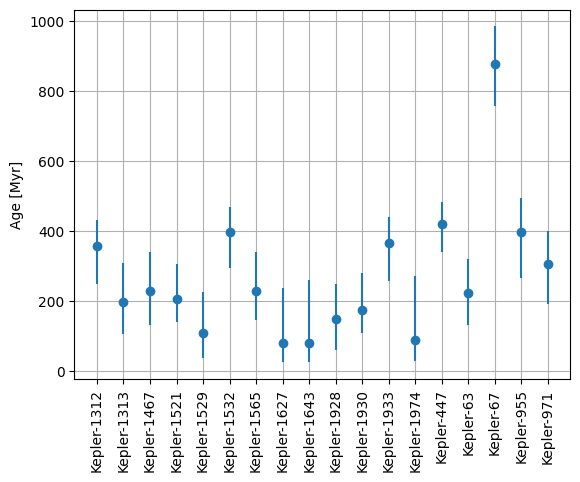

In [249]:
import matplotlib.pyplot as plt

known_planet = known_planet.sort_values(by='hostname')
x = known_planet.hostname
y = known_planet.tGyro
yerr1 = known_planet.e_tGyro
yerr2 = known_planet.E_tGyro
plt.errorbar(x, y, yerr=[yerr1, yerr2], marker='o', ls='')
plt.xticks(rotation=90);
plt.ylabel('Age [Myr]')
plt.grid()

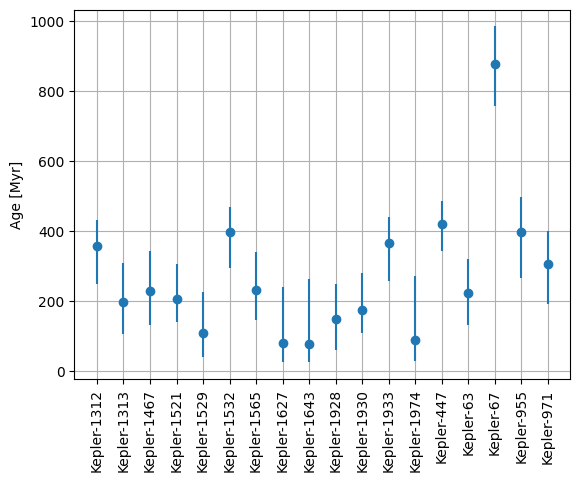

In [250]:
import matplotlib.pyplot as plt

gyro_age = gyro_age.sort_values(by='hostname')
x = gyro_age.hostname
y = gyro_age.age_med
yerr1 = gyro_age.age_lo
yerr2 = gyro_age.age_hi
plt.errorbar(x, y, yerr=[yerr1, yerr2], marker='o', ls='')
plt.xticks(rotation=90);
plt.ylabel('Age [Myr]')
plt.grid()

In [248]:
pd.merge(known_planet, gyro_age, on='hostname')[['hostname','tGyro','age_med']]

,hostname,tGyro,age_med
0,Kepler-1627,81.0,80.79
1,Kepler-1974,88.0,87.92
2,Kepler-1643,79.0,78.44
3,Kepler-1529,109.0,109.06
4,Kepler-1930,174.0,173.82
5,Kepler-1928,148.0,147.49
6,Kepler-1313,197.0,196.56
7,Kepler-1565,230.0,230.40
8,Kepler-1521,207.0,206.92
9,Kepler-63,223.0,222.98


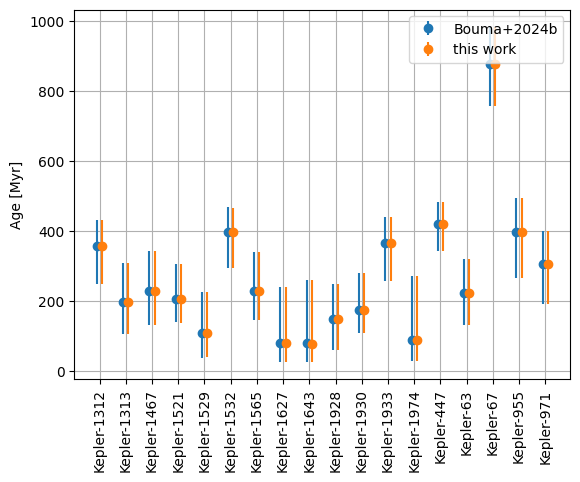

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# Combine hostnames and create x-axis positions
all_hostnames = np.unique(np.concatenate([known_planet.hostname, gyro_age.hostname]))
x_pos = {name: i for i, name in enumerate(all_hostnames)}

# Bouma+2024b
x = np.array([x_pos[name] for name in known_planet.hostname])
y = known_planet.tGyro
yerr1 = known_planet.e_tGyro
yerr2 = known_planet.E_tGyro
plt.errorbar(x - 0.1, y, yerr=[yerr1, yerr2], marker='o', ls='', label='Bouma+2024b')

# this work
x = np.array([x_pos[name] for name in gyro_age.hostname])
y = gyro_age.age_med
yerr1 = gyro_age.age_lo
yerr2 = gyro_age.age_hi
plt.errorbar(x + 0.1, y, yerr=[yerr1, yerr2], marker='o', ls='', label='this work')

# Adjust x-axis labels
plt.xticks(range(len(all_hostnames)), all_hostnames, rotation=90)
plt.ylabel('Age [Myr]')
plt.grid()
plt.legend()
plt.show()

In [252]:
name = 'Kepler-1627'
known_planet.query("hostname==@name")

,Prot,Teff,e_Prot,e_Teff,tGyro,E_tGyro,e_tGyro,tLi,E_tLi,e_tLi,ID,hostname
0,2.62,5357.0,0.026,95.0,81.0,158.0,55.0,51.0,38.0,27.0,Kepler-1627b,Kepler-1627


In [253]:
gyro_age.query("hostname==@name")

,Prot,Teff,age_med,age_lo,age_hi,hostname
7,7.4,4958.0,80.79,55.19,158.8,Kepler-1627


ages in Bouma+2024b is confirmed.